In [ ]:
# getting the library that has some of the functions needed for simulations
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time
from numba import njit, prange
import pandas as pd

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Data/CompStat'

/content/drive/My Drive/Data/CompStat


###### No Numba Section

In [ ]:
def cdf_inv_fr(u, gamma):
  return ((pow(-np.log(u) , -gamma)))

def cdf_inv_H(u , gamma, beta):
  return (pow(-np.log(u)/(pow(beta , -1/gamma)-1) , -gamma) )

def armax(beta , gamma, n, random_state = 124):
  x = np.zeros(n)
  r = np.random.RandomState(random_state)
  u = r.uniform(0,1,1)[0]
  x0 = cdf_inv_fr(u,gamma)
  xi_lag = x0
  x[0] = x0
  #print(x0)
  t = 1
  for i in range(n-1):
    r2 = np.random.RandomState(random_state + i)
    u = r2.uniform(0,1,1)[0]
    zi = cdf_inv_H(u,gamma,beta)
    xi = beta*max(xi_lag , zi)
    xi_lag = xi
    x[t] = xi
    t = t + 1
    #print(zi)
  return x

In [ ]:
armx1 = armax(0.2 , 1 , 100)
armx2 = armax(0.5 , 1 , 100)
armx3 = armax(0.8 , 1 , 100)

In [ ]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (20,6))
fig.suptitle('Fig 1: Sample Paths of the stationary Frechet (gamma = 1) ARMAX processes')
axs[0].plot(armx1, "--ko", ms = 4, mec = "k", mfc = "c")
axs[0].set_title('theta = 0.8')
axs[1].plot(armx2, '--ko', ms = 4, mec = "k", mfc = "c")
axs[1].set_title('theta = 0.5')
axs[2].plot(armx3, "--ko", ms = 4, mec = "k", mfc = "c")
axs[2].set_title("theta = 0.2")

In [ ]:
def theta_n_k(X, k_=1):
  sum = 0
  k = int(k_)

  X_k = np.partition(X, n-k-1)[n-k-1]
  #if k <= 1:
  # return 1

  #X_k = max(X[n-k:n])
  
  for j in range(n-1):
    # k-th top order equals n-k low order
    if X[j] <= X_k and X[j+1] > X_k:
      sum += 1

  if k == 0:
    return 1

  #if sum/k >= 1:
  #  return 1
  return sum/k

In [ ]:
def theta_GJ_k(X, k, delta):
  #n = X.shape[0]

  numerator = (delta*delta + 1) * theta_n_k(X, int(np.floor(delta*k)) + 1) - delta*(theta_n_k(X, int(np.floor(delta*delta*k)) + 1) + theta_n_k(X, k))
  denominator = (1 - delta)**2

  if numerator < 0: 
    return 0

  #return (numerator/denominator if numerator/denominator <= 1 else 1)
  return numerator/denominator

In [ ]:
# For figure 2
n = 1000

sample = np.array(armax(0.5, 1, n))

k_range = list(range(n))
straight_line = 0.5 * np.ones(n)

path1 = np.zeros(n)
path2 = np.zeros(n)

for k in k_range:
  path1[k] = theta_n_k(sample, k)
  path2[k] = theta_GJ_k(sample, k, delta = 0.25)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle('Fig 2: S')
axs[0].plot(k_range, path1, "r-")
axs[0].plot(k_range, path2, "b-")
axs[0].plot(k_range, straight_line, "k-")
axs[0].set_title('Linear')
axs[1].plot(k_range[1:], path1[1:], "r-")
axs[1].plot(k_range[1:], path2[1:], "b-")
axs[1].plot(k_range[1:], straight_line[1:], "k-")
axs[1].set_title('Logarithmic')
axs[1].set_xscale('log')
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
axs[0].set_xlim([0,1000])
axs[1].set_xlim([1,1000])

###### Numba parts

In [ ]:
@jit(nopython=True)
def cdf_inv_fr(u, gamma):
  return ((pow(-np.log(u) , -gamma)))

@jit(nopython=True)
def cdf_inv_H(u , gamma, beta):
  return (pow(-np.log(u)/(pow(beta , -1/gamma)-1) , -gamma) )

@jit(nopython=True)
def armax(beta , gamma, n):
  x = np.zeros(n)
  #r = np.random.RandomState(random_state)
  u = np.random.uniform(0,1,1)[0]
  x0 = cdf_inv_fr(u,gamma)
  xi_lag = x0
  x[0] = x0
  #print(x0)
  t = 1
  for i in range(n-1):
    #r2 = np.random.RandomState(random_state + i)
    u = np.random.uniform(0,1,1)[0]
    zi = cdf_inv_H(u,gamma,beta)
    xi = beta*max(xi_lag , zi)
    xi_lag = xi
    x[t] = xi
    t = t + 1
    #print(zi)
  return x

In [ ]:
@jit(nopython=True)
def theta_n_k(X, n, k_=1):
  sum = 0
  k = int(k_)

  X_k = np.partition(X, n-k-1)[n-k-1]
  #if k <= 1:
  # return 1

  #X_k = max(X[n-k:n])
  
  for j in range(n-1):
    # k-th top order equals n-k low order
    if X[j] <= X_k and X[j+1] > X_k:
      sum += 1

  if k == 0:
    return 1

  #if sum/k >= 1:
  #  return 1
  return sum/k


@jit(nopython=True)
def theta_GJ_k(X, n, k, delta):
  #n = X.shape[0]

  numerator = (delta*delta + 1) * theta_n_k(X,n, int(np.floor(delta*k)) + 1) - delta*(theta_n_k(X, n, int(np.floor(delta*delta*k)) + 1) + theta_n_k(X, n, k))
  denominator = (1 - delta)**2

  if numerator < 0: 
    return 0

  #return (numerator/denominator if numerator/denominator <= 1 else 1)
  return numerator/denominator

In [ ]:
@jit(nopython = True)
def np_apply_along_axis(func1d, axis, arr):
  assert arr.ndim == 2
  assert axis in [0, 1]
  if axis == 0:
    result = np.empty(arr.shape[1])
    for i in range(len(result)):
      result[i] = func1d(arr[:, i])
  else:
    result = np.empty(arr.shape[0])
    for i in range(len(result)):
      result[i] = func1d(arr[i, :])
  return result

In [ ]:
@jit(nopython=True)
def simulate_mean_mse(n, theta, runs = 15, replicates = 10):
  all_values_mean = np.zeros((runs, n))
  all_values_mse = np.zeros((runs, n))

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_n_k(a[j], n, k)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean[run] = np_apply_along_axis(np.mean, 0, path)
    all_values_mse[run] = np_apply_along_axis(np.mean, 0, path2)

  return np_apply_along_axis(np.mean, 0, all_values_mean), np_apply_along_axis(np.mean, 0, all_values_mse)

In [ ]:
@jit(nopython=True)
def simulate_mean_mse_GJ(n, theta, delta = 0.25, runs = 15, replicates = 10):
  all_values_mean = np.zeros((runs, n))
  all_values_mse = np.zeros((runs, n))

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_GJ_k(a[j], n, k, delta)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean[run] = np_apply_along_axis(np.mean, 0, path)
    all_values_mse[run] = np_apply_along_axis(np.mean, 0, path2)

  return np_apply_along_axis(np.mean, 0, all_values_mean), np_apply_along_axis(np.mean, 0, all_values_mse)

CPU times: user 3h 4min 18s, sys: 9.43 s, total: 3h 4min 27s
Wall time: 3h 4min 16s


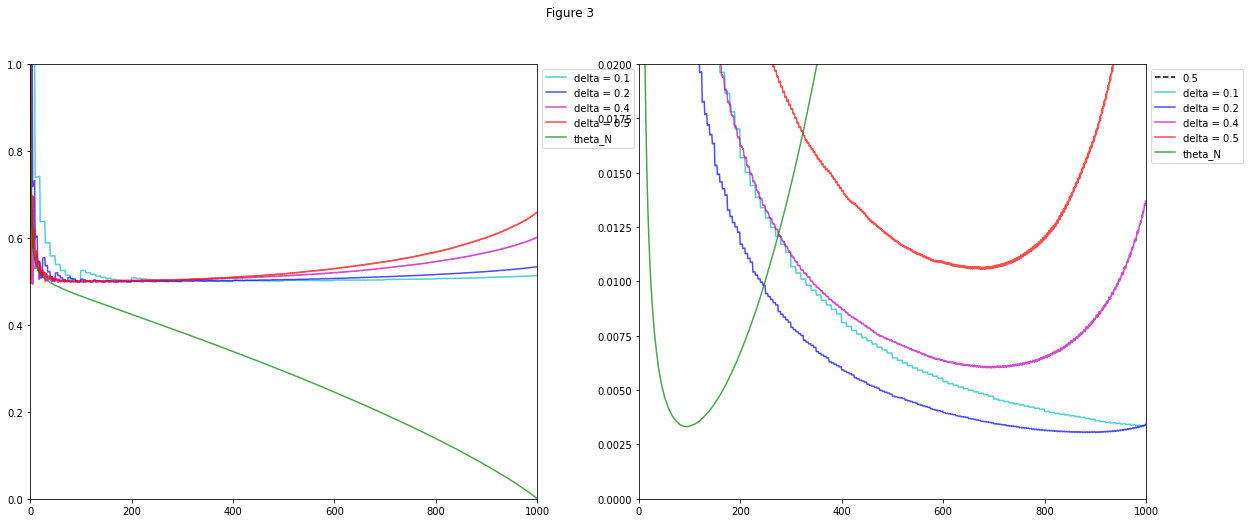

In [ ]:
%%time
runs = 5000
replicates = 10
n = 1000
theta = 0.5
e_1000_5, mse_1000_5 = simulate_mean_mse(n, theta, runs = runs, replicates = replicates)
e_1000_5_1, mse_1000_5_1 = simulate_mean_mse_GJ(n, theta, delta = 0.1, runs = runs, replicates = replicates)
e_1000_5_2, mse_1000_5_2 = simulate_mean_mse_GJ(n, theta, delta = 0.2, runs = runs, replicates = replicates)
e_1000_5_4, mse_1000_5_4 = simulate_mean_mse_GJ(n, theta, delta = 0.4, runs = runs, replicates = replicates)
e_1000_5_5, mse_1000_5_5 = simulate_mean_mse_GJ(n, theta, delta = 0.5, runs = runs, replicates = replicates)

k_range = np.arange(n)
straight_line = theta*np.ones(n)

a = 0.7
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 3")
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].plot(k_range, e_1000_5_1, 'c-', label = 'delta = 0.1', alpha = a)
axs[0].plot(k_range, e_1000_5_2, 'b-', label = 'delta = 0.2', alpha = a)
axs[0].plot(k_range, e_1000_5_4, 'm-', label = 'delta = 0.4', alpha = a)
axs[0].plot(k_range, e_1000_5_5, 'r-', label = 'delta = 0.5', alpha = a)
axs[0].plot(k_range, e_1000_5, 'g-', label = 'theta_N', alpha = a)
axs[1].plot(k_range, straight_line, 'k--', label = '0.5')
axs[0].legend(bbox_to_anchor=(1.2, 1))

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].plot(k_range, mse_1000_5_1, 'c-', label = 'delta = 0.1', alpha = a)
axs[1].plot(k_range, mse_1000_5_2, 'b-', label = 'delta = 0.2', alpha = a)
axs[1].plot(k_range, mse_1000_5_4, 'm-', label = 'delta = 0.4', alpha = a)
axs[1].plot(k_range, mse_1000_5_5, 'r-', label = 'delta = 0.5', alpha = a)
axs[1].plot(k_range, mse_1000_5, 'g-', label = 'theta_N', alpha = a)
axs[1].legend(bbox_to_anchor=(1.2, 1))

CPU times: user 47min 1s, sys: 2.39 s, total: 47min 3s
Wall time: 47min 1s


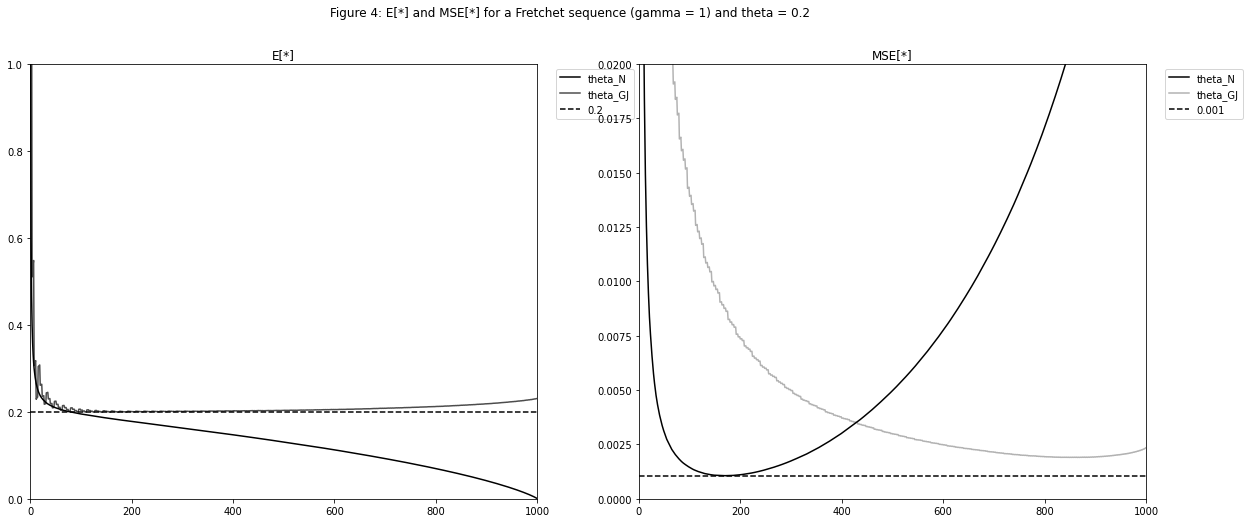

In [ ]:
%%time

n = 1000
theta = 0.2
alph = 0.3
delta = 0.25
runs = 5000
replicates = 10

e_1000_2, mse_1000_2 = simulate_mean_mse(n, theta, runs, replicates)
e_1000_2_25, mse_1000_2_25 = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

straight_line = theta*np.ones(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 4: E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta))
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_2, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1.2, 1))

m = mse_1000_2
mse_line = m[np.where(m == m.min())[0][0]] *np.ones(n)

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_2, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[1].plot(k_range, mse_line, 'k--', label = str(m[np.where(m == m.min())[0][0]])[:5])
axs[1].legend(bbox_to_anchor=(1.2, 1))

CPU times: user 57min 49s, sys: 5.09 s, total: 57min 54s
Wall time: 57min 49s


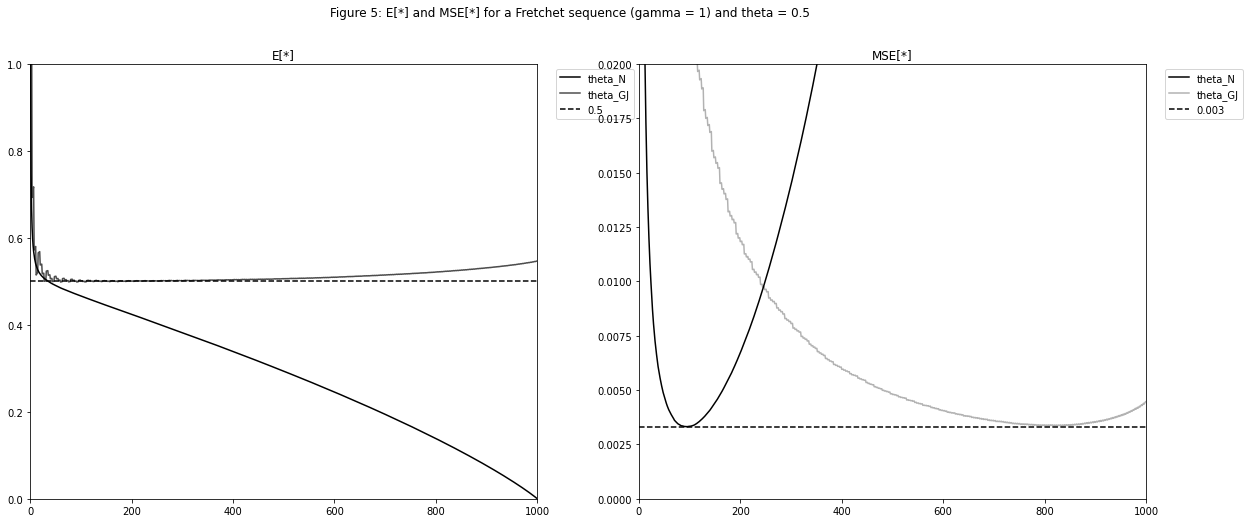

In [ ]:
%%time

n = 1000
theta = 0.5
alph = 0.3
delta = 0.25
runs = 5000
replicates = 10

e_1000_2, mse_1000_2 = simulate_mean_mse(n, theta, runs, replicates)
e_1000_2_25, mse_1000_2_25 = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

straight_line = theta*np.ones(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 5: E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta))
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_2, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1.2, 1))

m = mse_1000_2
mse_line = m[np.where(m == m.min())[0][0]] *np.ones(n)

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_2, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[1].plot(k_range, mse_line, 'k--', label = str(m[np.where(m == m.min())[0][0]])[:5])
axs[1].legend(bbox_to_anchor=(1.2, 1))

CPU times: user 1h 1min 45s, sys: 3.41 s, total: 1h 1min 48s
Wall time: 1h 1min 45s


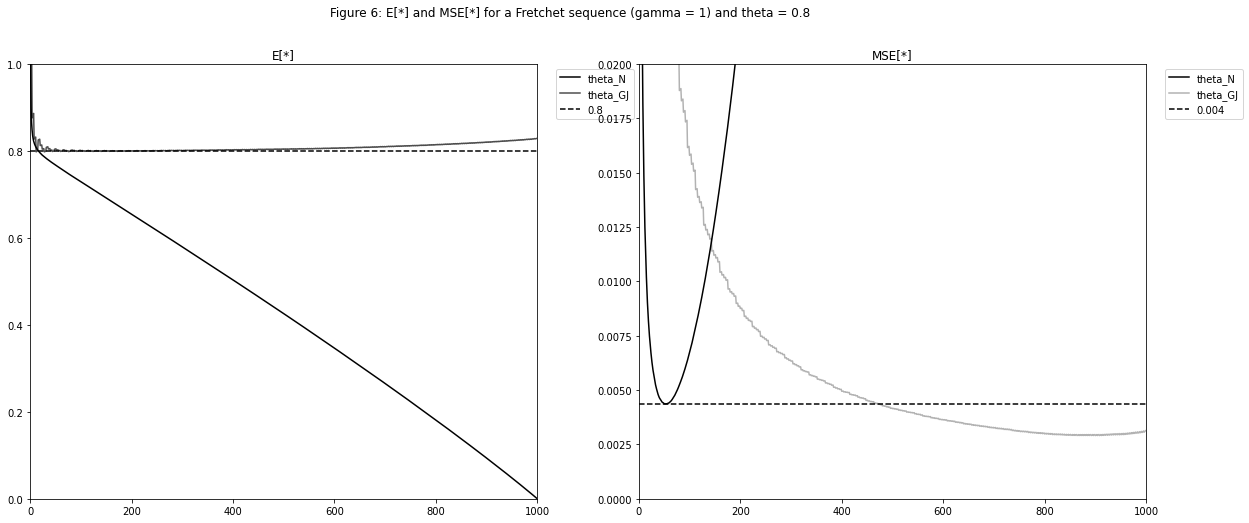

In [ ]:
%%time

n = 1000
theta = 0.8
alph = 0.3
delta = 0.25
runs = 5000
replicates = 10

e_1000_2, mse_1000_2 = simulate_mean_mse(n, theta, runs, replicates)
e_1000_2_25, mse_1000_2_25 = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

straight_line = theta*np.ones(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 6: E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta))
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_2, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1.2, 1))

m = mse_1000_2
mse_line = m[np.where(m == m.min())[0][0]] *np.ones(n)

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_2, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[1].plot(k_range, mse_line, 'k--', label = str(m[np.where(m == m.min())[0][0]])[:5])
axs[1].legend(bbox_to_anchor=(1.2, 1))

##### Table section

In [ ]:
@njit
def reff(mse_n, mse_gj):
  return np.sqrt(mse_n/mse_gj)

@njit
def bri(theta_n, theta_gj, theta):
  return np.abs((theta_n - theta)/(theta_gj - theta))

@njit
def sti(e_n, e_gj, theta, n, senstivity = 0.01):
  numerator = 0
  denominator = 0
  for i in range(n - 1):
    if np.abs(e_n[i] - theta) <= senstivity:
      denominator += 1
    if np.abs(e_gj[i] - theta) <= senstivity:
      numerator += 1
  return numerator/denominator

In [ ]:
n = 1000
theta = 0.8
runs = 50
replicates = 10
delta = 0.25

print("theta = {0} and n = {1}".format(theta, n))

e_n, mse_n = simulate_mean_mse(n, theta, runs, replicates)
e_gj, mse_gj = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

k_n = np.where(mse_n == mse_n.min())[0][0]
k_gj = np.where(mse_gj == mse_gj.min())[0][0]

print("k/n\t{0:.4f}".format((k_n + 1)/n) )
print("k_gj/n\t{0:.4f}".format((k_gj+1)/n))

print("E_N\t{0:.4f}".format(e_n[k_n]))
print("E_GJ\t{0:.4f}".format(e_gj[k_gj]))

print("MSE_N\t{0:.4f}".format(mse_n[k_n]))
print("MSE_GJ\t{0:.4f}".format(mse_gj[k_gj]))

print("REFF\t{0:.4f}".format(reff(mse_n[k_n], mse_gj[k_gj])))
print("BRI\t{0:.4f}".format(bri(e_n[k_n], e_gj[k_gj], 0.8)))
print("STI\t{0:.4f}".format(sti(e_n, e_gj, 0.8, 1000)))

theta = 0.8 and n = 1000
k/n	0.0550
k_gj/n	0.9570
E_N	0.7645
E_GJ	0.8233
MSE_N	0.0041
MSE_GJ	0.0032
REFF	1.1299
BRI	1.5255
STI	50.3333


In [ ]:
ns = [100, 200, 500, 1000, 2000, 5000, 10000]
thetas = [0.2, 0.5, 0.8]

runs = 15
replicates = 10
delta = 0.25

kns = np.zeros((len(thetas), len(ns)))
kgjs = np.zeros((len(thetas), len(ns)))
ens = np.zeros((len(thetas), len(ns)))
egjs = np.zeros((len(thetas), len(ns)))
mses = np.zeros((len(thetas), len(ns)))
msegjs = np.zeros((len(thetas), len(ns)))
reffs = np.zeros((len(thetas), len(ns)))
bris = np.zeros((len(thetas), len(ns)))
stis = np.zeros((len(thetas), len(ns)))

start = time.time()
i = 0
for theta in thetas:
  j = 0
  for n in ns:
    print("theta = {0} and n = {1}".format(theta, n))

    e_n, mse_n = simulate_mean_mse(n, theta, runs, replicates)
    e_gj, mse_gj = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

    k_n = np.where(mse_n == mse_n.min())[0][0]
    k_gj = np.where(mse_gj == mse_gj.min())[0][0]

    print("k/n\t{0:.4f}".format((k_n + 1)/n) )
    print("k_gj/n\t{0:.4f}".format((k_gj+1)/n))

    kns[i][j] = (k_n + 1)/n
    kgjs[i][j] = (k_gj + 1)/n

    print("E_N\t{0:.4f}".format(e_n[k_n]))
    print("E_GJ\t{0:.4f}".format(e_gj[k_gj]))

    ens[i][j] = e_n[k_n]
    egjs[i][j] = e_gj[k_gj]

    print("MSE_N\t{0:.4f}".format(mse_n[k_n]))
    print("MSE_GJ\t{0:.4f}".format(mse_gj[k_gj]))

    mses[i][j] = mse_n[k_n]
    msegjs[i][j] = mse_gj[k_gj]

    print("REFF\t{0:.4f}".format(reff(mse_n[k_n], mse_gj[k_gj])))
    print("BRI\t{0:.4f}".format(bri(e_n[k_n], e_gj[k_gj], theta)))
    print("STI\t{0:.4f}".format(sti(e_n, e_gj, theta, n)))

    reffs[i][j] = reff(mse_n[k_n], mse_gj[k_gj])
    bris[i][j] = bri(e_n[k_n], e_gj[k_gj], theta)
    stis[i][j] = sti(e_n, e_gj, theta, n)
    end = time.time()
    print("Time =", end - start, "\n")

    j += 1
  print("\n\n")
  i += 1

theta = 0.2 and n = 100
k/n	0.3300
k_gj/n	0.9700
E_N	0.1729
E_GJ	0.2070
MSE_N	0.0035
MSE_GJ	0.0119
REFF	0.5456
BRI	3.8604
STI	9.0000
Time = 0.15551376342773438 

theta = 0.2 and n = 200
k/n	0.2700
k_gj/n	0.9850
E_N	0.1795
E_GJ	0.2383
MSE_N	0.0025
MSE_GJ	0.0087
REFF	0.5414
BRI	0.5351
STI	1.1429
Time = 0.5715560913085938 

theta = 0.2 and n = 500
k/n	0.2040
k_gj/n	0.8980
E_N	0.1847
E_GJ	0.2123
MSE_N	0.0013
MSE_GJ	0.0036
REFF	0.6121
BRI	1.2478
STI	8.2927
Time = 2.7668426036834717 

theta = 0.2 and n = 1000
k/n	0.1740
k_gj/n	0.8010
E_N	0.1867
E_GJ	0.2153
MSE_N	0.0006
MSE_GJ	0.0015
REFF	0.6474
BRI	0.8638
STI	2.7065
Time = 11.298882246017456 

theta = 0.2 and n = 2000
k/n	0.1335
k_gj/n	0.7285
E_N	0.1864
E_GJ	0.2082
MSE_N	0.0007
MSE_GJ	0.0009
REFF	0.8628
BRI	1.6555
STI	9.3097
Time = 44.08199954032898 

theta = 0.2 and n = 5000
k/n	0.1178
k_gj/n	0.7156
E_N	0.1874
E_GJ	0.2048
MSE_N	0.0004
MSE_GJ	0.0004
REFF	0.9858
BRI	2.6105
STI	10.9516
Time = 242.65604758262634 

theta = 0.2 and n = 10000
k/n	

In [ ]:
np.save("kn.npy", kns)
np.save("k_gj.npy", kgjs)
np.save("e_n.py", ens)
np.save("e_gj.npy", egjs)
np.save("mse_n.npy", mses)
np.save("mse_gj.npy", msegjs)
np.save("reff.npy", reffs)
np.save("bri.npy", bris)
np.save("sti.npy", stis)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Data/CompStat'

/content/drive/My Drive/Data/CompStat


In [ ]:
import pandas as pd

In [ ]:
my_dict = {'theta': [theta] * len(ns),'kn': kns[0], 'kgj' : kgjs[0], 'en': ens[0], 'egj': egjs[0], 'msen': mses[0], 'mse_gj': msegjs[0], 'reff': reffs[0], 'bri': bris[0], 'sti': stis[0]}
df = pd.DataFrame.from_dict(my_dict, orient='index', columns=ns)
df.to_csv("df.csv")

In [ ]:
def k_ass(theta, n):
  a = 2*(1 - theta)*n*n
  b = theta * (1 + theta) * (1 + theta)
  return np.power(a/b, 1/3)

In [ ]:
k_ass_s = np.zeros((len(thetas), len(ns)))
i = 0
for theta in thetas:
  j = 0
  for n in ns:
    print("theta = {0:.1f} and n = {1}: \t {2:.4f}".format(theta, n, k_ass(theta, n)))
    k_ass_s[i][j] = k_ass(theta, n)
    j += 1
  i += 1
  print()

theta = 0.2 and n = 100: 	 38.1571
theta = 0.2 and n = 200: 	 60.5707
theta = 0.2 and n = 500: 	 111.5722
theta = 0.2 and n = 1000: 	 177.1098
theta = 0.2 and n = 2000: 	 281.1442
theta = 0.2 and n = 5000: 	 517.8721
theta = 0.2 and n = 10000: 	 822.0707

theta = 0.5 and n = 100: 	 20.7149
theta = 0.5 and n = 200: 	 32.8828
theta = 0.5 and n = 500: 	 60.5707
theta = 0.5 and n = 1000: 	 96.1500
theta = 0.5 and n = 2000: 	 152.6286
theta = 0.5 and n = 5000: 	 281.1442
theta = 0.5 and n = 10000: 	 446.2886

theta = 0.8 and n = 100: 	 11.5560
theta = 0.8 and n = 200: 	 18.3440
theta = 0.8 and n = 500: 	 33.7900
theta = 0.8 and n = 1000: 	 53.6383
theta = 0.8 and n = 2000: 	 85.1455
theta = 0.8 and n = 5000: 	 156.8393
theta = 0.8 and n = 10000: 	 248.9669



In [ ]:
df2 = pd.DataFrame(k_ass_s, index = thetas, columns = ns)

In [ ]:
df2

,100,200,500,1000,2000,5000,10000
0.2,38.157141,60.570686,111.572158,177.109762,281.144222,517.872084,822.070691
0.5,20.714883,32.882828,60.570686,96.149971,152.628566,281.144222,446.288633
0.8,11.556021,18.344040,33.790011,53.638299,85.145492,156.839338,248.966930


In [ ]:
df2.to_csv("k_ass.csv")

In [ ]:
@njit(parallel = True)
def theta_n_k_1(X, n, k_=1):
  sum = 0
  k = int(k_)

  X_k = np.partition(X, n-k-1)[n-k-1]
  #if k <= 1:
  # return 1

  #X_k = max(X[n-k:n])
  
  for j in prange(n-1):
    # k-th top order equals n-k low order
    if X[j] <= X_k and X[j+1] > X_k:
      sum += 1

  if k == 0:
    return 1

  #if sum/k >= 1:
  #  return 1
  return sum/k


@njit(parallel = True)
def theta_GJ_k_1(X, n, k, delta):
  #n = X.shape[0]

  numerator = (delta*delta + 1) * theta_n_k_1(X,n, int(np.floor(delta*k)) + 1) - delta*(theta_n_k_1(X, n, int(np.floor(delta*delta*k)) + 1) + theta_n_k_1(X, n, k))
  denominator = (1 - delta)**2

  if numerator < 0: 
    return 0

  #return (numerator/denominator if numerator/denominator <= 1 else 1)
  return numerator/denominator

In [ ]:
@njit(parallel = True)
def simulate_mean_mse_1(n, theta, runs = 15, replicates = 10):
  all_values_mean = np.zeros((runs, n))
  all_values_mse = np.zeros((runs, n))

  #print("Theta_N", end = "")
  for run in prange(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in prange(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    #k_range = list(range(n))

    for k in prange(n):
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in prange(replicates):
        path[j][k] = theta_n_k_1(a[j], n, k)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean[run] = np_apply_along_axis(np.mean, 0, path)
    all_values_mse[run] = np_apply_along_axis(np.mean, 0, path2)

  return np_apply_along_axis(np.mean, 0, all_values_mean), np_apply_along_axis(np.mean, 0, all_values_mse)

@njit(parallel = True)
def simulate_mean_mse_GJ_1(n, theta, delta = 0.25, runs = 15, replicates = 10):
  all_values_mean = np.zeros((runs, n))
  all_values_mse = np.zeros((runs, n))

  #print("Theta_N", end = "")
  for run in prange(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in prange(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    #k_range = list(range(n))

    for k in prange(n):
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in prange(replicates):
        path[j][k] = theta_GJ_k_1(a[j], n, k, delta)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean[run] = np_apply_along_axis(np.mean, 0, path)
    all_values_mse[run] = np_apply_along_axis(np.mean, 0, path2)

  return np_apply_along_axis(np.mean, 0, all_values_mean), np_apply_along_axis(np.mean, 0, all_values_mse)


CPU times: user 55.5 s, sys: 207 ms, total: 55.7 s
Wall time: 28.2 s


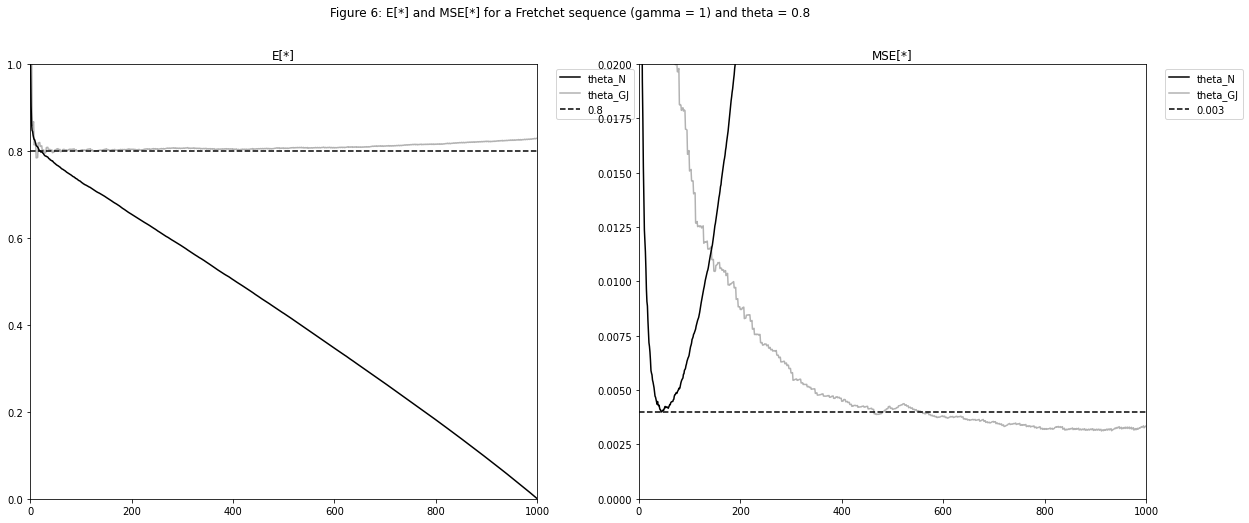

In [ ]:
%%time

n = 1000
theta = 0.8
alph = 0.3
delta = 0.25
runs = 50
replicates = 10

e_1000_2, mse_1000_2 = simulate_mean_mse_1(n, theta, runs, replicates)
e_1000_2_25, mse_1000_2_25 = simulate_mean_mse_GJ_1(n, theta, delta, runs, replicates)
k_range = list(range(n))

straight_line = theta*np.ones(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 6: E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta))
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_2, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1.2, 1))

m = mse_1000_2
mse_line = m[np.where(m == m.min())[0][0]] *np.ones(n)

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_2, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[1].plot(k_range, mse_line, 'k--', label = str(m[np.where(m == m.min())[0][0]])[:5])
axs[1].legend(bbox_to_anchor=(1.2, 1))

CPU times: user 40.5 s, sys: 52.1 ms, total: 40.5 s
Wall time: 40.5 s


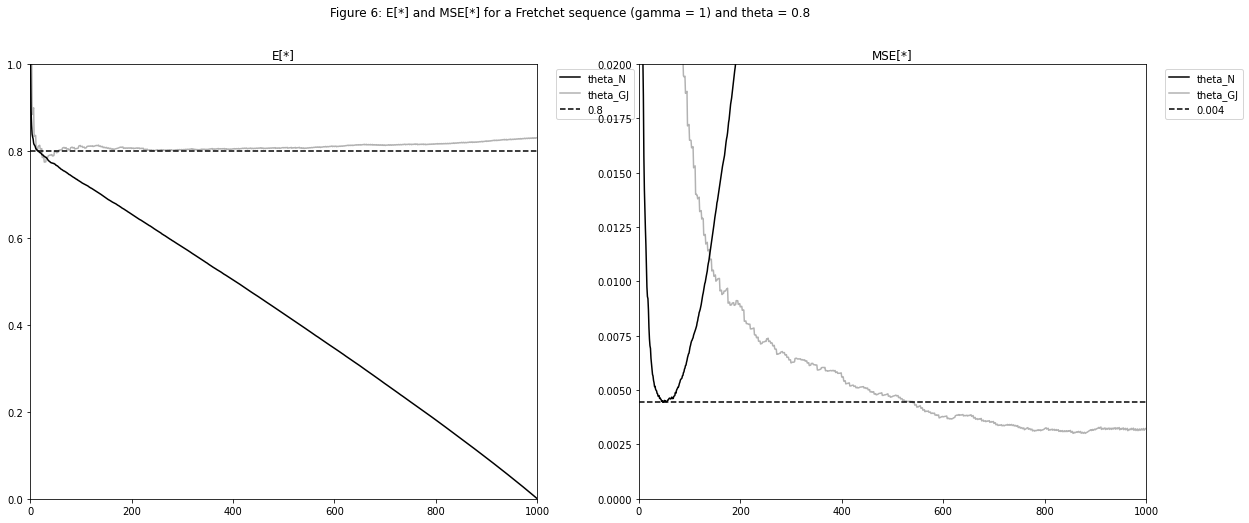

In [ ]:
%%time

n = 1000
theta = 0.8
alph = 0.3
delta = 0.25
runs = 50
replicates = 10

e_1000_2, mse_1000_2 = simulate_mean_mse(n, theta, runs, replicates)
e_1000_2_25, mse_1000_2_25 = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

straight_line = theta*np.ones(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 6: E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta))
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_2, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1.2, 1))

m = mse_1000_2
mse_line = m[np.where(m == m.min())[0][0]] *np.ones(n)

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_2, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_2_25, 'k-', label = 'theta_GJ', alpha = alph)
axs[1].plot(k_range, mse_line, 'k--', label = str(m[np.where(m == m.min())[0][0]])[:5])
axs[1].legend(bbox_to_anchor=(1.2, 1))

In [ ]:
def reff(mse_n, mse_gj):
  return np.sqrt(mse_n/mse_gj)

def bri(theta_n, theta_gj, theta):
  return np.abs((theta_n - theta)/(theta_gj - theta))

def sti(e_n, e_gj, theta, n, senstivity = 0.01):
  numerator = 0
  denominator = 0
  for i in range(n - 1):
    if np.abs(e_n[i] - theta) <= senstivity:
      denominator += 1
    if np.abs(e_gj[i] - theta) <= senstivity:
      numerator += 1
  return numerator/denominator

In [ ]:
ns = [2000,5000]

"""
CHANGES
PLEASE MAKE NECESSARY CHANGES BEFORE RUNNING

change theta = the value assigned to you

Values assigned:
Praveen: 0.2
Parth: 0.5
Nitin: 0.8
"""
theta = 0.5

runs = 5000
replicates = 10
delta = 0.25

kns = np.zeros(len(ns))
kgjs = np.zeros(len(ns))
ens = np.zeros(len(ns))
egjs = np.zeros(len(ns))
mses = np.zeros(len(ns))
msegjs = np.zeros(len(ns))
reffs = np.zeros(len(ns))
bris = np.zeros(len(ns))
stis = np.zeros(len(ns))

start = time.time()
i = 0

for n in ns:
  print("theta = {0} and n = {1}".format(theta, n))

  e_n, mse_n = simulate_mean_mse(n, theta, runs, replicates)
  e_gj, mse_gj = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

  k_n = np.where(mse_n == mse_n.min())[0][0]
  k_gj = np.where(mse_gj == mse_gj.min())[0][0]

  print("k/n\t{0:.4f}".format((k_n + 1)/n) )
  print("k_gj/n\t{0:.4f}".format((k_gj+1)/n))

  kns[i] = (k_n + 1)/n
  kgjs[i] = (k_gj + 1)/n

  print("E_N\t{0:.4f}".format(e_n[k_n]))
  print("E_GJ\t{0:.4f}".format(e_gj[k_gj]))

  ens[i] = e_n[k_n]
  egjs[i] = e_gj[k_gj]

  print("MSE_N\t{0:.4f}".format(mse_n[k_n]))
  print("MSE_GJ\t{0:.4f}".format(mse_gj[k_gj]))

  mses[i] = mse_n[k_n]
  msegjs[i] = mse_gj[k_gj]

  print("REFF\t{0:.4f}".format(reff(mse_n[k_n], mse_gj[k_gj])))
  print("BRI\t{0:.4f}".format(bri(e_n[k_n], e_gj[k_gj], theta)))
  print("STI\t{0:.4f}".format(sti(e_n, e_gj, theta, n)))

  reffs[i] = reff(mse_n[k_n], mse_gj[k_gj])
  bris[i] = bri(e_n[k_n], e_gj[k_gj], theta)
  stis[i] = sti(e_n, e_gj, theta, n)
  end = time.time()
  print("Time =", end - start, "\n")

  i += 1

In [ ]:
my_dict = {'kn': kns, 'kgj' : kgjs, 'en': ens, 'egj': egjs, 'msen': mses, 'mse_gj': msegjs, 'reff': reffs, 'bri': bris, 'sti': stis}
df = pd.DataFrame.from_dict(my_dict, orient='index', columns=ns)
df.to_csv("df_2000_5000.csv")

NameError: ignored

#### New section

In [ ]:
"""n = 1000
theta = 0.8
runs = 50
replicates = 10
delta = 0.25

print("theta = {0} and n = {1}".format(theta, n))

e_n, mse_n = simulate_mean_mse(n, theta, runs, replicates)
e_gj, mse_gj = simulate_mean_mse_GJ(n, theta, delta, runs, replicates)

k_n = np.where(mse_n == mse_n.min())[0][0]
k_gj = np.where(mse_gj == mse_gj.min())[0][0]

print("k/n\t{0:.4f}".format((k_n + 1)/n) )
print("k_gj/n\t{0:.4f}".format((k_gj+1)/n))

print("E_N\t{0:.4f}".format(e_n[k_n]))
print("E_GJ\t{0:.4f}".format(e_gj[k_gj]))

print("MSE_N\t{0:.4f}".format(mse_n[k_n]))
print("MSE_GJ\t{0:.4f}".format(mse_gj[k_gj]))

print("REFF\t{0:.4f}".format(reff(mse_n[k_n], mse_gj[k_gj])))
print("BRI\t{0:.4f}".format(bri(e_n[k_n], e_gj[k_gj], 0.8)))
print("STI\t{0:.4f}".format(sti(e_n, e_gj, 0.8, 1000))) """

In [ ]:
@jit(nopython=True)
def simulate_mean_mse_1(n, theta, runs = 15, replicates = 10):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  k_range = list(range(n))

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_n_k(a[j], n, k)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean += np_apply_along_axis(np.mean, 0, path)
    all_values_mse += np_apply_along_axis(np.mean, 0, path2)


  return all_values_mean/runs, all_values_mse/runs

In [ ]:
@jit(nopython=True)
def simulate_mean_mse_GJ_1(n, theta, delta = 0.25, runs = 15, replicates = 10):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  k_range = list(range(n))

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_GJ_k(a[j], n, k, delta)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean += np_apply_along_axis(np.mean, 0, path)
    all_values_mse += np_apply_along_axis(np.mean, 0, path2)

  return all_values_mean/runs, all_values_mse/runs

In [ ]:
%%time
e1, m1 = simulate_mean_mse(1000, 0.5)
e2, m2 = simulate_mean_mse_GJ(1000, 0.5)

CPU times: user 17.9 s, sys: 65.4 ms, total: 17.9 s
Wall time: 17.9 s


In [ ]:
%%time
e1, m1 = simulate_mean_mse_1(1000, 0.5)
e2, m2 = simulate_mean_mse_GJ_1(1000, 0.5)

CPU times: user 12.7 s, sys: 26.7 ms, total: 12.7 s
Wall time: 12.7 s


In [ ]:
%%time
ns = [5000]

"""
CHANGES
PLEASE MAKE NECESSARY CHANGES BEFORE RUNNING

change theta = the value assigned to you

Values assigned:
Praveen: 0.2
Parth: 0.5
Nitin: 0.8
"""
theta = 0.5

runs = 5000
replicates = 10
delta = 0.25

kns = np.zeros(len(ns))
kgjs = np.zeros(len(ns))
ens = np.zeros(len(ns))
egjs = np.zeros(len(ns))
mses = np.zeros(len(ns))
msegjs = np.zeros(len(ns))
reffs = np.zeros(len(ns))
bris = np.zeros(len(ns))
stis = np.zeros(len(ns))

start = time.time()
i = 0

for n in ns:
  print("theta = {0} and n = {1}".format(theta, n))

  e_n, mse_n = simulate_mean_mse_1(n, theta, runs, replicates)
  e_gj, mse_gj = simulate_mean_mse_GJ_1(n, theta, delta, runs, replicates)

  k_n = np.where(mse_n == mse_n.min())[0][0]
  k_gj = np.where(mse_gj == mse_gj.min())[0][0]

  print("k/n\t{0:.4f}".format((k_n + 1)/n) )
  print("k_gj/n\t{0:.4f}".format((k_gj+1)/n))

  kns[i] = (k_n + 1)/n
  kgjs[i] = (k_gj + 1)/n

  print("E_N\t{0:.4f}".format(e_n[k_n]))
  print("E_GJ\t{0:.4f}".format(e_gj[k_gj]))

  ens[i] = e_n[k_n]
  egjs[i] = e_gj[k_gj]

  print("MSE_N\t{0:.4f}".format(mse_n[k_n]))
  print("MSE_GJ\t{0:.4f}".format(mse_gj[k_gj]))

  mses[i] = mse_n[k_n]
  msegjs[i] = mse_gj[k_gj]

  print("REFF\t{0:.4f}".format(reff(mse_n[k_n], mse_gj[k_gj])))
  print("BRI\t{0:.4f}".format(bri(e_n[k_n], e_gj[k_gj], theta)))
  print("STI\t{0:.4f}".format(sti(e_n, e_gj, theta, n)))

  reffs[i] = reff(mse_n[k_n], mse_gj[k_gj])
  bris[i] = bri(e_n[k_n], e_gj[k_gj], theta)
  stis[i] = sti(e_n, e_gj, theta, n)
  end = time.time()
  print("Time =", end - start, "\n")

  i += 1

my_dict = {'theta': [theta] * len(ns),'kn': kns[0], 'kgj' : kgjs[0], 'en': ens[0], 'egj': egjs[0], 'msen': mses[0], 'mse_gj': msegjs[0], 'reff': reffs[0], 'bri': bris[0], 'sti': stis[0]}
df = pd.DataFrame.from_dict(my_dict, orient='index', columns=ns)
df.to_csv("df_5000_05.csv")

theta = 0.5 and n = 5000
